In [1]:
%pip install numpy scikit-learn joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cicddos2019/Syn-training.parquet
/kaggle/input/cicddos2019/UDPLag-testing.parquet
/kaggle/input/cicddos2019/NetBIOS-testing.parquet
/kaggle/input/cicddos2019/Portmap-training.parquet
/kaggle/input/cicddos2019/Syn-testing.parquet
/kaggle/input/cicddos2019/MSSQL-testing.parquet
/kaggle/input/cicddos2019/SNMP-testing.parquet
/kaggle/input/cicddos2019/UDPLag-training.parquet
/kaggle/input/cicddos2019/NTP-testing.parquet
/kaggle/input/cicddos2019/LDAP-testing.parquet
/kaggle/input/cicddos2019/UDP-training.parquet
/kaggle/input/cicddos2019/NetBIOS-training.parquet
/kaggle/input/cicddos2019/DNS-testing.parquet
/kaggle/input/cicddos2019/UDP-testing.parquet
/kaggle/input/cicddos2019/LDAP-training.parquet
/kaggle/input/cicddos2019/TFTP-testing.parquet
/kaggle/input/cicddos2019/MSSQL-training.parquet


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from scipy import stats

In [4]:
def get_feature_types(df, target_col='Attack Type'):
    """
    Identify numeric and categorical features, if present, in the dataset.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    target_col : str, optional (default='Attack Type')
        Name of the target column to exclude from features

    Returns:
    --------
    tuple : (list, list)
        Two lists containing:
        - numeric_features: List of column names with numerical data
        - categorical_features: List of column names with categorical data

    Notes:
    ------
    - Numerical features are identified as columns containing numeric data types
    - Categorical features are identified as columns containing object data types
    - The target column is excluded from both feature lists if present
    """

    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Remove target column if present
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features

In [5]:
# 2. Correlation analysis (df, numeric_features) -> list of tuples with highly correlaed features
def correlation_analysis(df, numeric_features, threshold=0.85):
    """
    Analyze correlations between numerical features.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to analyze
    threshold : float
        Threshold for determining highly correlated features (default='0.85')

    Returns:
    --------
    list of tuples
        List of highly correlated feature pairs and their correlation values
        Each tuple contains (feature1, feature2, correlation_value)

    Notes:
    ------
    - Generates a correlation matrix heatmap
    - Identifies feature pairs with absolute correlation > 0.85
    - Only returns upper triangle of correlation matrix to avoid duplicates
    - The heatmap uses a diverging color scheme centered at 0
    """

    # Calculate correlation matrix
    corr_matrix = df[numeric_features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidth = 0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Identify highly correlated features
    threshold = threshold
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]

    return high_corr

In [6]:
def analyze_feature_importance(df, numeric_features, target_col='Attack Type'):
    """  
    Analyze feature importance using the Kruskal-Wallis test.  

    Parameters:  
    -----------  
    df : pandas.DataFrame  
        Input DataFrame containing the dataset  
    numeric_features : list  
        List of column names containing numerical features to analyze  
    target_col : str, optional (default='Attack Type')
        Name of the target column

    Returns:  
    --------  
    pandas.DataFrame  
        DataFrame containing H-statistics and p-values for each feature,  
        sorted by H-statistic in descending order  

    Notes:  
    ------  
    - Uses the Kruskal-Wallis test to assess feature importance  
    - Higher H-statistic indicates stronger relationship with target variable  
    - Generates bar plot of H-statistics for visual comparison  
    - Features are sorted by importance in the visualization  
    """  

    h_scores = {}  
    
    for feature in numeric_features:  
        # Group data by y and perform the Kruskal-Wallis test  
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)]  
        h_stat, p_val = stats.kruskal(*groups)  
        h_scores[feature] = {'H-statistic': h_stat, 'p-value': p_val}  

    # Create a DataFrame from the results  
    h_scores_df = pd.DataFrame.from_dict(h_scores, orient='index')  
    h_scores_df = h_scores_df.sort_values('H-statistic', ascending=False)  

    # Plotting H-statistics  
    plt.figure(figsize=(18, 10))  
    plt.bar(range(len(h_scores_df)), h_scores_df['H-statistic'], color='skyblue')  
    plt.xticks(range(len(h_scores_df)), h_scores_df.index, rotation=90)  
    plt.title('Feature Importance based on H-statistic (Kruskal-Wallis Test)')  
    plt.xlabel('Features')  
    plt.ylabel('H-statistic')  
    plt.tight_layout()  
    plt.show()  

    return h_scores_df

In [7]:
def analyze_feature_importance_rf(df, numeric_features, target_col='Attack Type'):
    """
    Analyze feature importance using a Random Forest classifier.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to analyze
    target_col : str
        Column name of the target variable

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing feature importances sorted by importance in descending order
    cm
        Confusion Matrix for further analysis
    rf_labels
        Labels for plotting the confusion matrix
    cv_scores
        Cross-validation scores for future reference

    Notes:
    ------
    - Uses a Random Forest classifier to assess feature importance.
    - Generates bar plot of feature importances for visual comparison.
    """

    # Hyperparameter settings
    hyperparameters = {
        'n_estimators': 150,    # Number of trees
        'max_depth': 30,        # Limit tree depth
        'random_state': 42,     # For reproducibility
        'n_jobs': -1            # Use all available cores
    }

    # Prepare the data
    X = df[numeric_features]
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=hyperparameters['random_state'], stratify=y)

    # Create the Random Forest model with specified hyperparameters
    rf = RandomForestClassifier(**hyperparameters)

    # Fit the model on the training set
    rf.fit(X_train, y_train)

    # Cross-validation on the training set
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
    print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')
    
    # Predict on test set
    y_pred = rf.predict(X_test)

    # Feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': numeric_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Confusion matrix
    rf_labels = rf.classes_
    cm = confusion_matrix(y_test, y_pred)

    # Calculate test scores
    report = classification_report(y_test, y_pred, target_names=rf_labels)
    print("\nClassification Report:\n")
    print(report, end='\n\n')

    # Plot feature importances
    plt.figure(figsize=(18, 12))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Feature Importance from Random Forest')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return feature_importance_df, cm, rf_labels, cv_scores

In [8]:
import os
import pandas as pd
from collections import defaultdict

# Define dataset directory
data_dir = "/kaggle/input/cicddos2019/"

# Get all available files
files = os.listdir(data_dir)

# Group files by base name (without "training" or "testing")
file_groups = defaultdict(set)

for file in files:
    base_name = file.replace("-training.parquet", "").replace("-testing.parquet", "")
    if "training" in file:
        file_groups[base_name].add("training")
    elif "testing" in file:
        file_groups[base_name].add("testing")

# Keep only datasets that have both training & testing files
valid_datasets = [k for k, v in file_groups.items() if len(v) == 2]
print("Valid datasets:", valid_datasets)

merged_training = []
merged_testing = []

for name in valid_datasets:
    train_file = os.path.join(data_dir, f"{name}-training.parquet")
    test_file = os.path.join(data_dir, f"{name}-testing.parquet")

    # Convert and merge training files
    train_df = pd.read_parquet(train_file)
    train_df.to_csv(f"/kaggle/working/{name}-training.csv", index=False)
    merged_training.append(train_df)

    # Convert and merge testing files
    test_df = pd.read_parquet(test_file)
    test_df.to_csv(f"/kaggle/working/{name}-testing.csv", index=False)
    merged_testing.append(test_df)

# Save final merged CSVs
if merged_training:
    pd.concat(merged_training, ignore_index=True).to_csv("/kaggle/working/training_data.csv", index=False)
if merged_testing:
    pd.concat(merged_testing, ignore_index=True).to_csv("/kaggle/working/testing_data.csv", index=False)

print(" Merged CSV files saved in /kaggle/working/")

Valid datasets: ['Syn', 'UDPLag', 'NetBIOS', 'MSSQL', 'LDAP', 'UDP']
 Merged CSV files saved in /kaggle/working/


In [9]:
train = pd.read_csv("/kaggle/working/training_data.csv")

# Display the first 5 rows of each dataset
print("Training Data:")
display(train.head())


Training Data:


,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,105,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn
1,6,1,2,0,12.0,0.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn
2,6,55295858,8,0,48.0,0.0,6.0,6.0,6.0,0.0,...,20,1.0,0.0,1.0,1.0,18431952.0,4641289.0,22000140.0,13184826.0,Syn
3,6,49,2,0,12.0,0.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn
4,6,109,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn


In [10]:
drop_columns = [ # this list includes all spellings across CIC NIDS datasets
    "Flow ID",    
    'Fwd Header Length.1',
    "Source IP", "Src IP",
    "Source Port", "Src Port",
    "Destination IP", "Dst IP",
    "Destination Port", "Dst Port",
    "Timestamp",
    "Unnamed: 0", "Inbound", "SimillarHTTP" # CIC-DDoS other undocumented columns
]

In [11]:
train.drop(columns=drop_columns, errors="ignore", inplace=True)


In [12]:
print(f"Dataset Dimensions: {train.shape}")

Dataset Dimensions: (120065, 78)


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120065 entries, 0 to 120064
Data columns (total 78 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Protocol                  120065 non-null  int64  
 1   Flow Duration             120065 non-null  int64  
 2   Total Fwd Packets         120065 non-null  int64  
 3   Total Backward Packets    120065 non-null  int64  
 4   Fwd Packets Length Total  120065 non-null  float64
 5   Bwd Packets Length Total  120065 non-null  float64
 6   Fwd Packet Length Max     120065 non-null  float64
 7   Fwd Packet Length Min     120065 non-null  float64
 8   Fwd Packet Length Mean    120065 non-null  float64
 9   Fwd Packet Length Std     120065 non-null  float64
 10  Bwd Packet Length Max     120065 non-null  float64
 11  Bwd Packet Length Min     120065 non-null  float64
 12  Bwd Packet Length Mean    120065 non-null  float64
 13  Bwd Packet Length Std     120065 non-null  f

In [14]:
missing_values = train.isna().sum()
missing_percentage = (missing_values / len(train)) * 100

# Printing columns with missing values
for column, count in missing_values.items():
    if count != 0:
        print(f"Column '{column}' has {count} missing values, which is {missing_percentage[column]:.2f}% of the total")

In [15]:
col_names = {col: col.strip() for col in train.columns}
train.rename(columns = col_names, inplace = True)

In [16]:
duplicates = train.duplicated()
duplicate_count = duplicates.sum()

# Output results
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 3195


In [17]:
train = train.drop_duplicates(keep='first')
del duplicates
train.shape

(116870, 78)

In [18]:
identical_columns = {}
columns = train.columns
list_control = columns.copy().tolist()

# Compare each pair of columns
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if train[col1].equals(train[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

# Print the result
if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd Packet Length Mean' is identical to ['Avg Fwd Segment Size']
'Bwd Packet Length Mean' is identical to ['Avg Bwd Segment Size']
'Fwd PSH Flags' is identical to ['RST Flag Count']
'Bwd PSH Flags' is identical to ['Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count', 'PSH Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


In [19]:
for key, value in identical_columns.items():
    train.drop(columns=value, inplace=True)

In [20]:
print(train.columns)
train.shape

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'SYN Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count',
       'Down/

(116870, 62)

In [21]:
num_columns = train.select_dtypes(include = np.number).columns
has_infinite = np.isinf(train[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Series([], dtype: int64)


In [22]:
attack_counts = train['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = train.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,Syn,47246,47246,0,0.0
1,Benign,40980,40980,0,0.0
2,UDP,17795,17795,0,0.0
3,MSSQL,8434,8434,0,0.0
4,LDAP,1885,1885,0,0.0
5,NetBIOS,475,475,0,0.0
6,UDPLag,55,55,0,0.0


In [23]:
label_mapping = {
    'DrDoS_UDP': 'UDP',
    'DrDoS_MSSQL': 'MSSQL',
    'DrDoS_LDAP': 'LDAP',
    'DrDoS_NetBIOS': 'NetBIOS',
    'UDP-lag': 'UDPLag',
    'Syn': 'Syn',
    'Benign': 'Benign'
}

# Drop WebDDoS


# Apply the label mapping
train['Label'] = train['Label'].replace(label_mapping)

# Print the cleaned test set to verify
print(train['Label'].value_counts())

Label
Syn        47246
Benign     40980
UDP        17795
MSSQL       8434
LDAP        1885
NetBIOS      475
UDPLag        55
Name: count, dtype: int64


In [24]:
threshold = 10
missing_percentage = (train.isnull().sum() / len(train)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


In [25]:
row_missing_percentage = (train.isna().sum(axis=1) / train.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = train.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    116870.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

Total rows with missing values: 0


In [26]:
train.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,105,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn
1,6,1,2,0,12.0,0.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn
2,6,55295858,8,0,48.0,0.0,6.0,6.0,6.0,0.0,...,20,1.0,0.0,1.0,1.0,18431952.0,4641289.0,22000140.0,13184826.0,Syn
3,6,49,2,0,12.0,0.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn
4,6,109,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn


In [27]:
only_unique_cols = []
for col in train.columns:
    if len(train[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

Bwd PSH Flags

The number of columns with only one unique values is: 1


In [28]:
train.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [29]:
train['Attack Type'] = train['Label']

train['Attack Type'].value_counts()

In [30]:
train.drop(columns='Label', inplace=True)

In [31]:
train.drop(train[(train['Attack Type'] == 'UDPLag')].index, inplace=True)

In [32]:
train['Attack Type'].value_counts()

Attack Type
Syn        47246
Benign     40980
UDP        17795
MSSQL       8434
LDAP        1885
NetBIOS      475
Name: count, dtype: int64

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


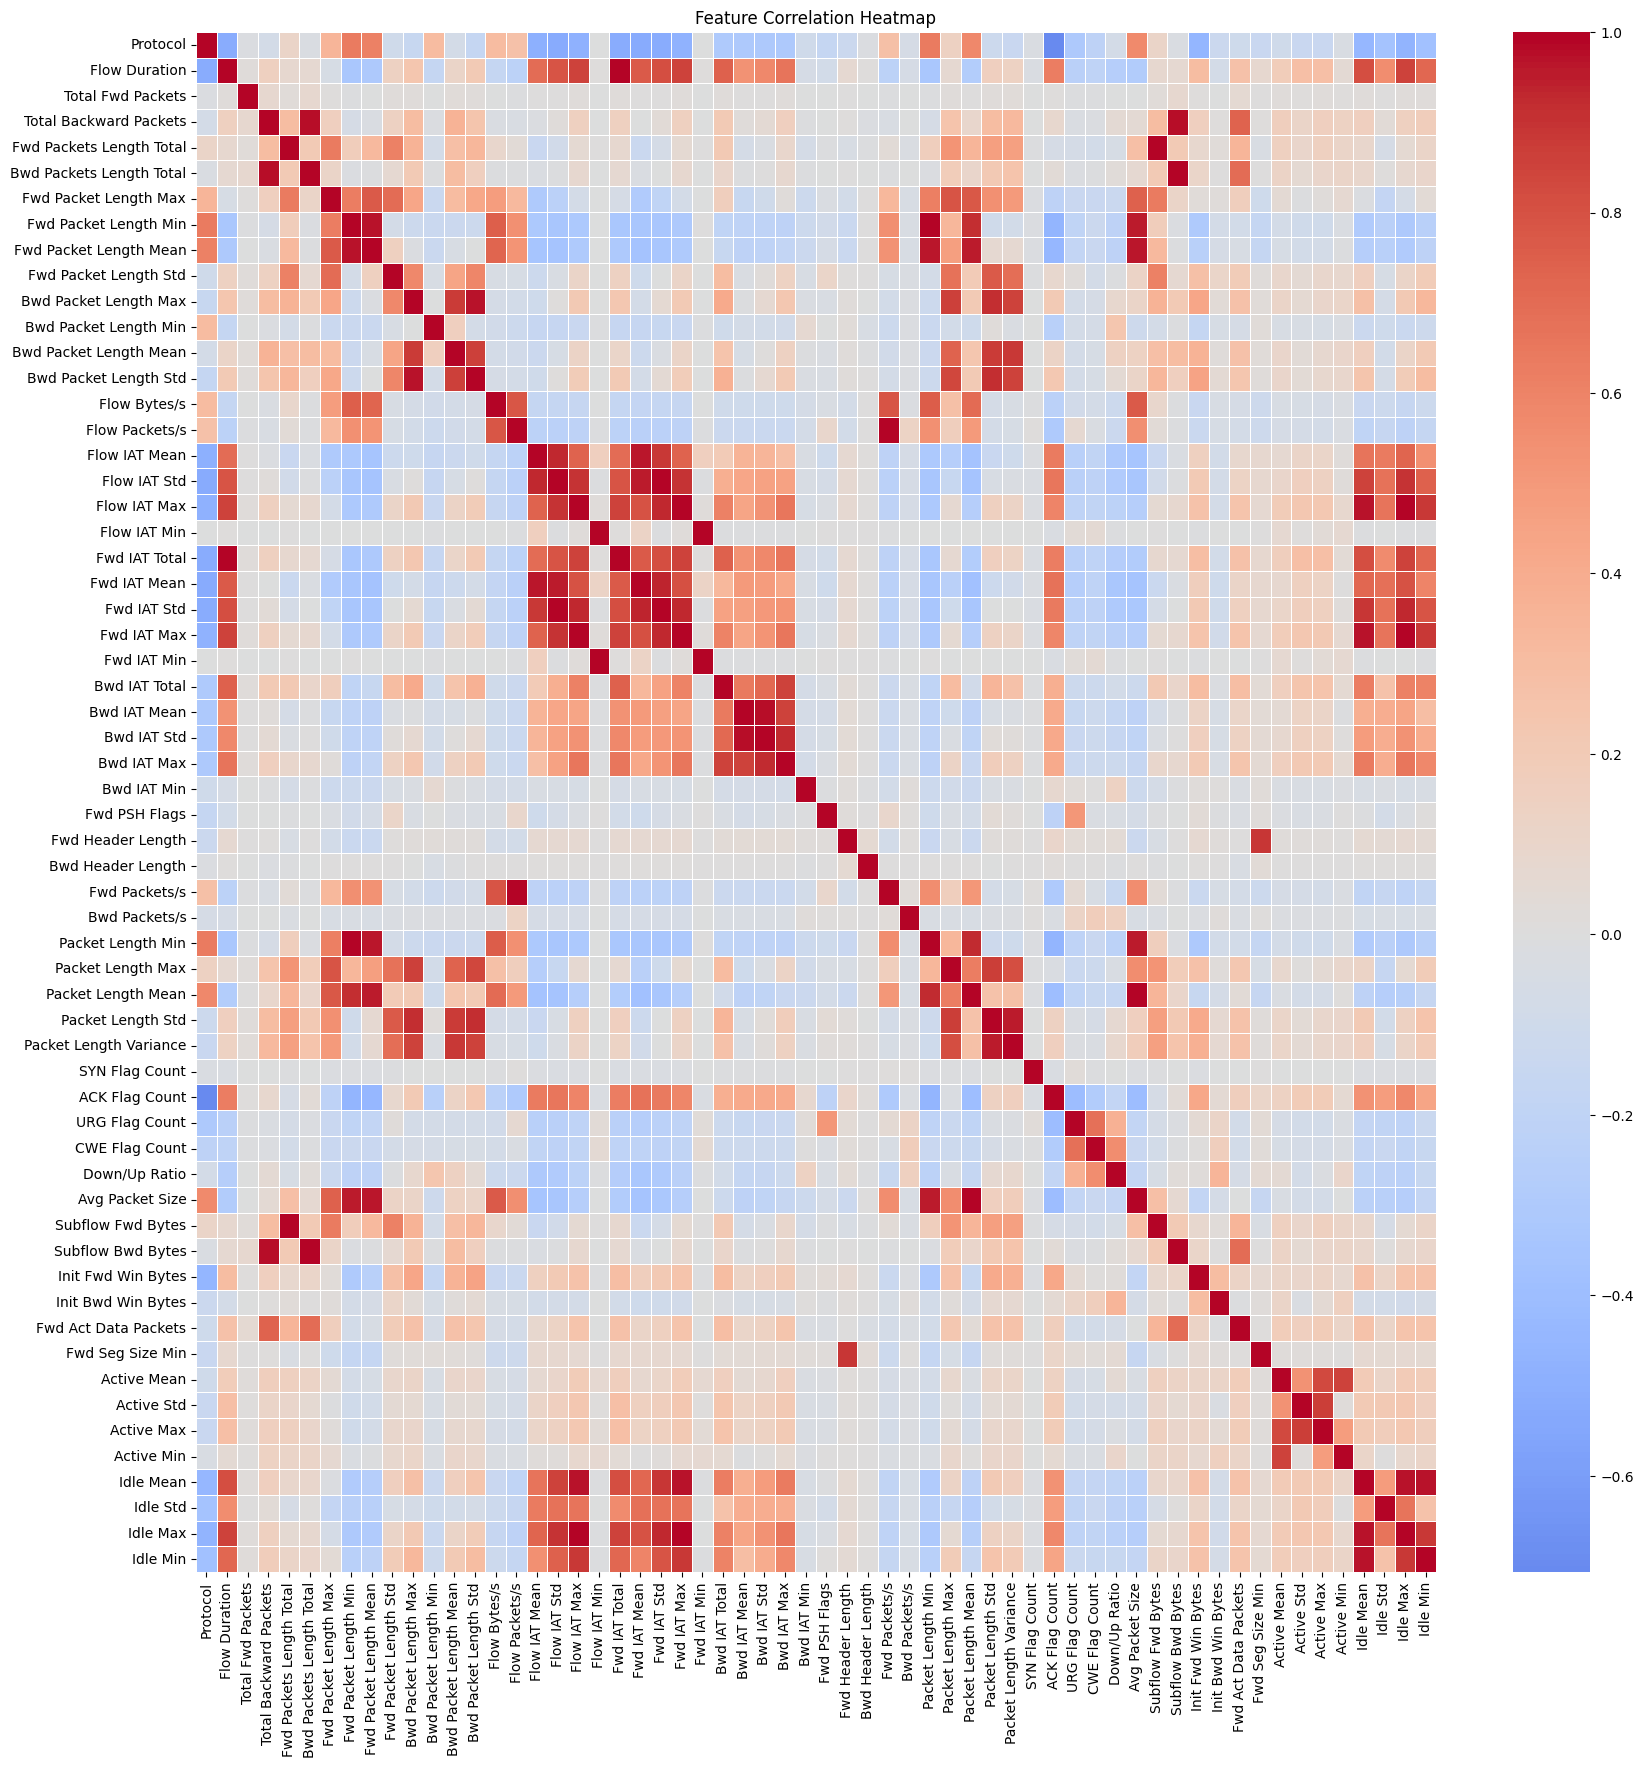

In [33]:
numeric_features, categorical_features = get_feature_types(train)
high_corr = correlation_analysis(train, numeric_features)

In [34]:
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Flow Duration has a high correlation with Flow IAT Max: 0.8509
Flow Duration has a high correlation with Fwd IAT Total: 0.9993
Flow Duration has a high correlation with Fwd IAT Max: 0.8513
Flow Duration has a high correlation with Idle Max: 0.8524
Total Backward Packets has a high correlation with Bwd Packets Length Total: 0.9758
Total Backward Packets has a high correlation with Subflow Bwd Bytes: 0.9758
Fwd Packets Length Total has a high correlation with Subflow Fwd Bytes: 1.0
Bwd Packets Length Total has a high correlation with Subflow Bwd Bytes: 1.0
Fwd Packet Length Min has a high correlation with Fwd Packet Length Mean: 0.9721
Fwd Packet Length Min has a high correlation with Packet Length Min: 0.9923
Fwd Packet Length Min has a high correlation with Packet Length Mean: 0.9197
Fwd Packet Length Min has a high correlation with Avg Packet Size: 0.9519
Fwd Packet Length Mean has a high correlation with Packet Length Min: 0.9643
Fwd Packet Length Mean has a high correlation with Pac

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


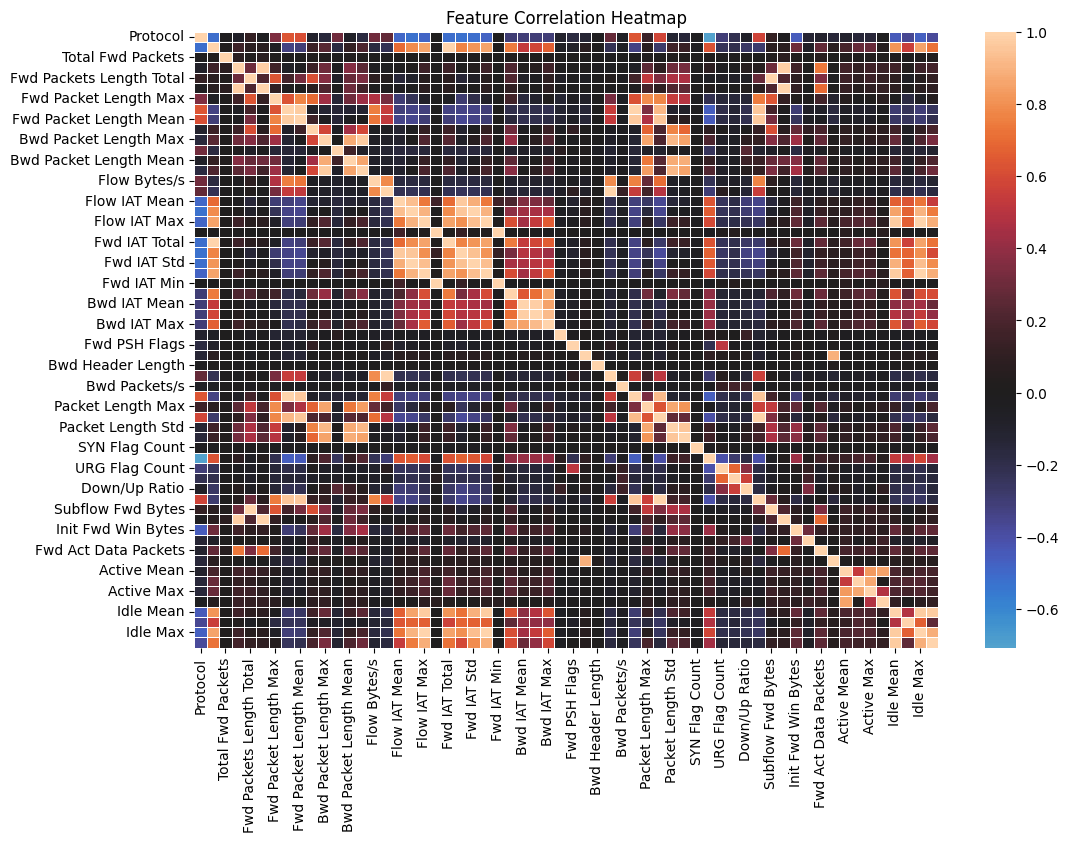

Removed features: ['Bwd Packets Length Total', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']


In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def correlation(df, numeric_features, threshold=0.85, plot=True):
    """
    Analyze correlations between numerical features and return the correlation matrix.
    """

    # Compute the correlation matrix
    corr_matrix = df[numeric_features].corr()

    if plot:
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=False, center=0, linewidths=0.5)
        plt.title('Feature Correlation Heatmap')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.show()

    return corr_matrix

# Generate the correlation matrix
corr_matrix = correlation(train, numeric_features)

# Create an upper triangle mask to ignore duplicate pairs
mask = np.triu(np.ones(corr_matrix.shape), k=1)

# Convert mask into a DataFrame (same shape as correlation matrix)
mask_df = pd.DataFrame(mask, index=corr_matrix.index, columns=corr_matrix.columns)

# Find feature pairs with high correlation (above 0.8)
to_drop = [column for column in corr_matrix.columns if any(corr_matrix.loc[mask_df[column] == 1, column] > 0.8)]

# Drop one of the highly correlated features
df_reduced = train.drop(columns=to_drop)

print(f"Removed features: {to_drop}")




In [36]:
train.shape

(116815, 61)

In [37]:
attack_counts_df = train['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Counting the total for each attack on both cases
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Calculating the respective percentages
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

print(attack_counts_df)

  Attack Type  Number of Occurrences  % of Total
0         Syn                  47246       40.45
1      Benign                  40980       35.08
2         UDP                  17795       15.23
3       MSSQL                   8434        7.22
4        LDAP                   1885        1.61
5     NetBIOS                    475        0.41


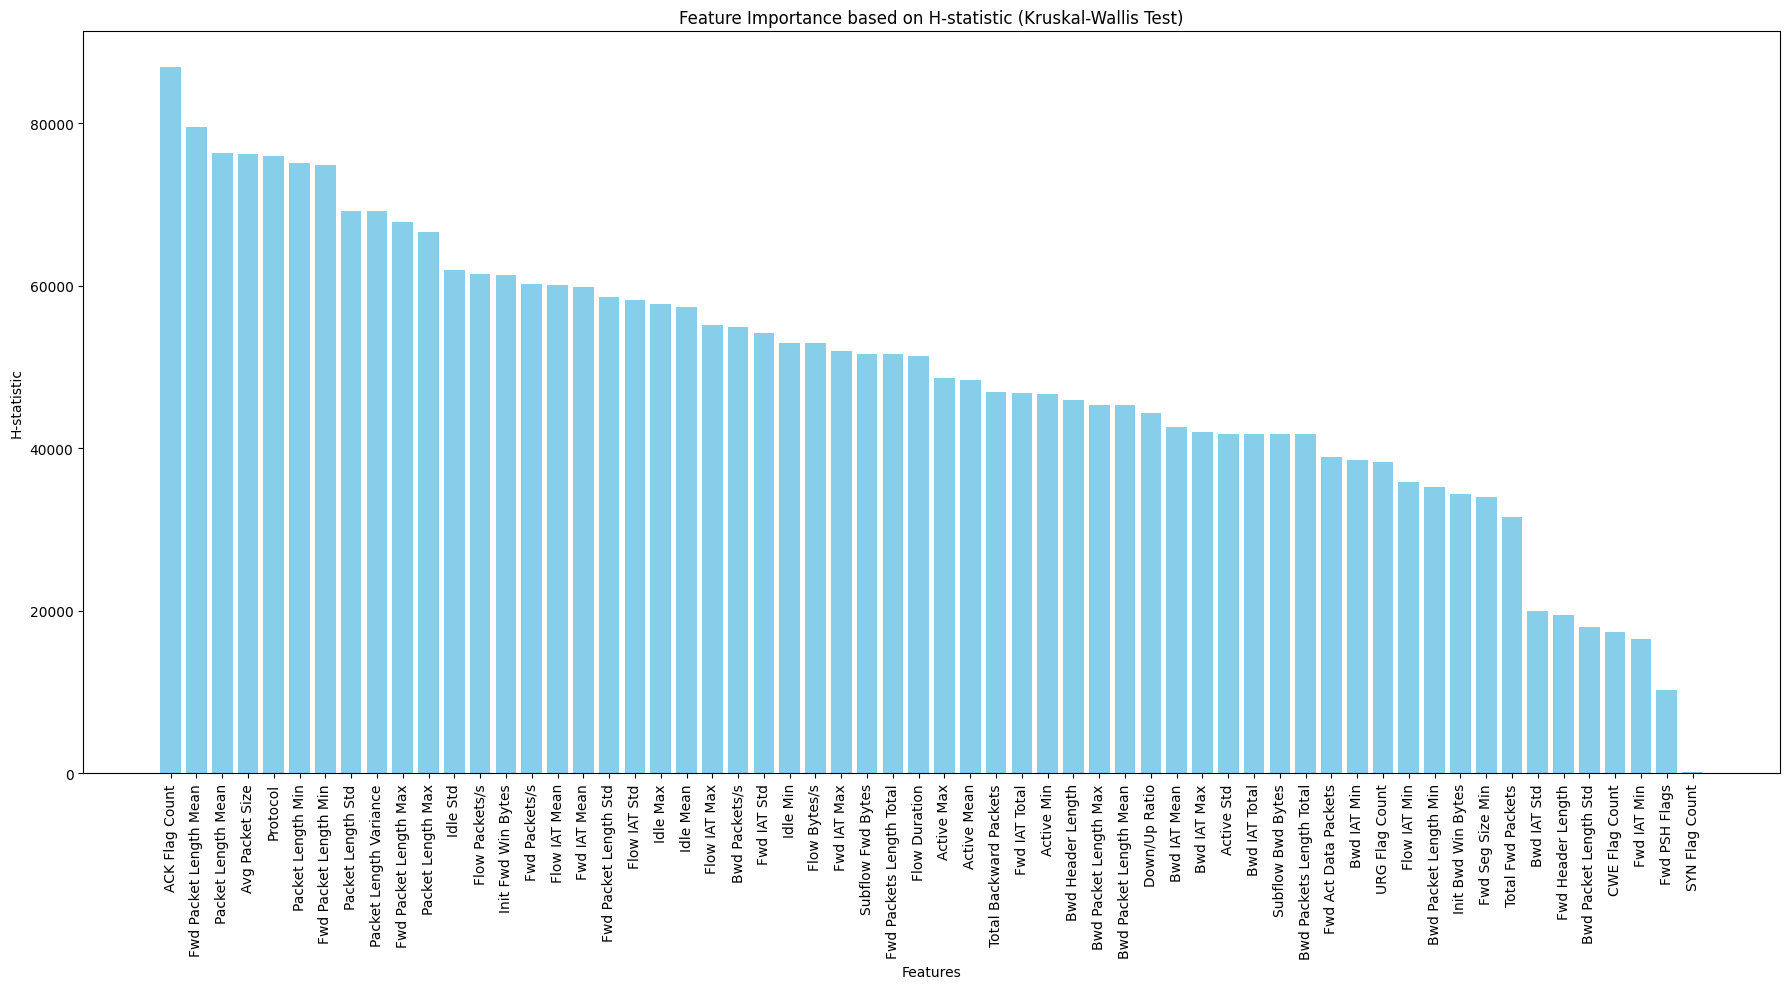

In [38]:
h_p_stats = analyze_feature_importance(train, numeric_features)

Cross-Validation Score: 0.9921 ± 0.0004

Classification Report:

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     12294
        LDAP       0.93      0.94      0.93       566
       MSSQL       0.95      0.96      0.96      2530
     NetBIOS       0.97      0.99      0.98       142
         Syn       1.00      1.00      1.00     14174
         UDP       0.99      0.98      0.99      5339

    accuracy                           0.99     35045
   macro avg       0.97      0.98      0.98     35045
weighted avg       0.99      0.99      0.99     35045




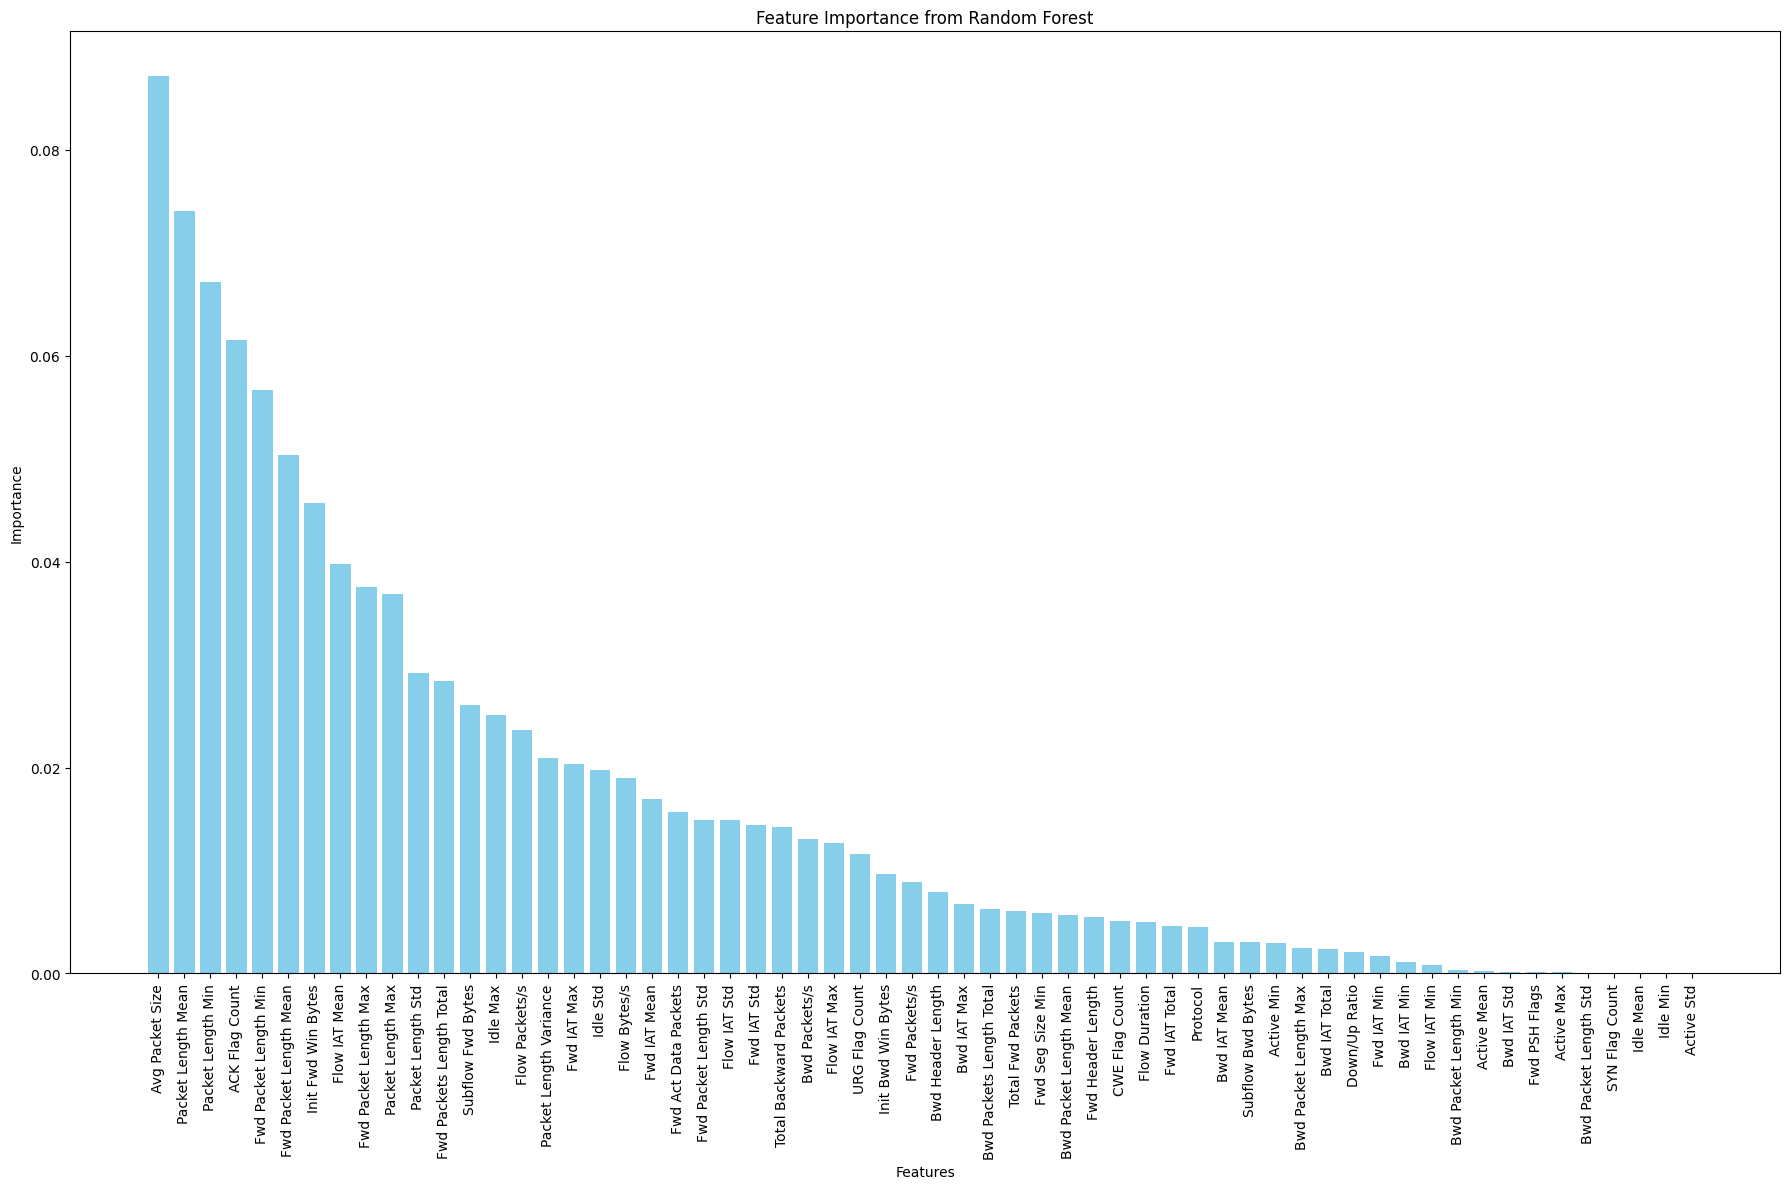

In [39]:
feature_importance_tree, cm, rf_labels, cv_scores = analyze_feature_importance_rf(train, numeric_features)

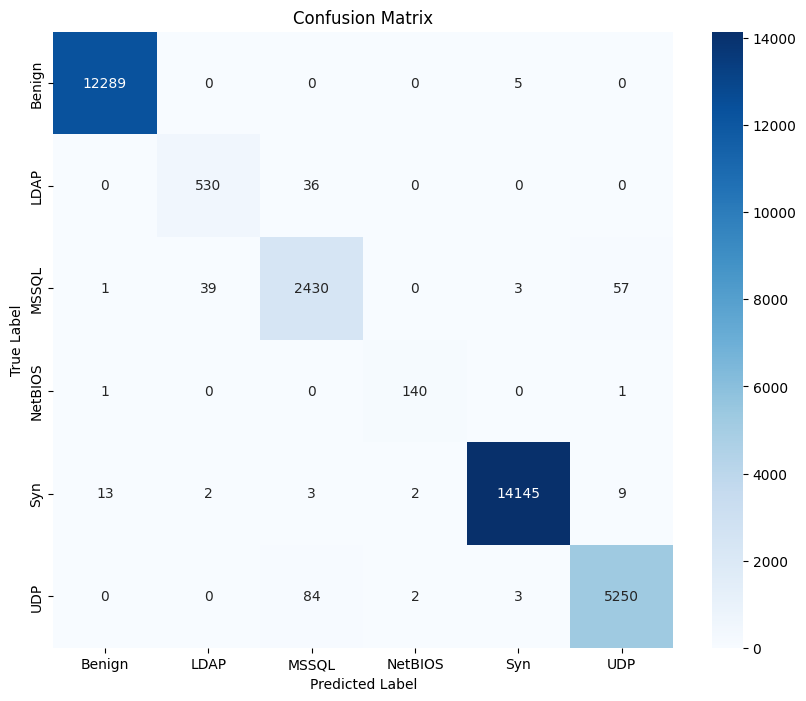

In [40]:
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_labels, yticklabels=rf_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [41]:
train.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count',
       'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio',
       'Avg P

In [42]:
# import numpy as np
# import pandas as pd
# # 1. Thay đổi import
# from sklearn.ensemble import RandomForestClassifier 
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score

# # Step 1: Split the dataset
# X = train.drop(columns=['Attack Type'])  # Replace 'target_column' with your actual target variable
# y = train['Attack Type']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Giả sử X_train và X_test là các DataFrame ban đầu
# top_features = ['Packet Length Mean', 'Avg Packet Size', 'ACK Flag Count', 'Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Init Fwd Win Bytes', 'Fwd Packet Length Max', 'Flow IAT Mean', 'Packet Length Max', 'Subflow Fwd Bytes', 'Fwd Packets Length Total', 'Flow Packets/s', 'Packet Length Std', 'Idle Max', 'Flow Bytes/s', 'Fwd IAT Max', 'Idle Std', 'Total Backward Packets', 'Fwd IAT Mean']

# # Step 2: Define the Random Forest model and perform hyperparameter tuning
# param_grid = {
#     'n_estimators': [100, 150],
#     'max_depth': [10, 20, None], 
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'criterion': ['gini', 'entropy']
# }

# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Step 3: Train the best Random Forest model
# best_rf = grid_search.best_estimator_
# best_rf.fit(X_train, y_train)

# # Step 4: Get feature importance scores
# feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': best_rf.feature_importances_})

# # Step 5: Sort by importance and keep the top 20 features
# top_features = feature_importances.sort_values(by='Importance', ascending=False).head(20)['Feature'].tolist()

# # Step 6: Keep only selected features in the dataset
# X_train_selected = X_train[top_features]
# X_test_selected = X_test[top_features]

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

top_features = ['Attack Type', 'Packet Length Mean', 'Avg Packet Size', 'ACK Flag Count', 'Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Init Fwd Win Bytes', 'Fwd Packet Length Max', 'Flow IAT Mean', 'Packet Length Max', 'Subflow Fwd Bytes', 'Fwd Packets Length Total', 'Flow Packets/s', 'Packet Length Std', 'Idle Max', 'Flow Bytes/s', 'Fwd IAT Max', 'Idle Std', 'Total Backward Packets', 'Fwd IAT Mean']

train = train[top_features]

X = train.drop(columns=['Attack Type'])  # Replace 'target_column' with your actual target variable
y = train['Attack Type']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo mô hình với các tham số tối ưu
best_rf_model = RandomForestClassifier(
    criterion='gini',
    max_depth=20,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=150,
    random_state=42,
    n_jobs=-1  # Sử dụng tất cả các lõi CPU để tăng tốc độ
)

# Huấn luyện mô hình
print("Bắt đầu huấn luyện Random Forest...")
best_rf_model.fit(X_train, y_train)
print("Huấn luyện hoàn tất.")

Bắt đầu huấn luyện Random Forest...
Huấn luyện hoàn tất.


In [43]:
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy with 20 selected features: {accuracy * 100.:4f}%")

Model accuracy with 20 selected features: 99.400762%


In [44]:
test = pd.read_csv("/kaggle/working/testing_data.csv", encoding="utf-8")
top_features_test = ['Packet Length Mean', 'Avg Packet Size', 'ACK Flag Count', 'Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Init Fwd Win Bytes', 'Fwd Packet Length Max', 'Flow IAT Mean', 'Packet Length Max', 'Subflow Fwd Bytes', 'Fwd Packets Length Total', 'Flow Packets/s', 'Packet Length Std', 'Idle Max', 'Flow Bytes/s', 'Fwd IAT Max', 'Idle Std', 'Total Backward Packets', 'Fwd IAT Mean']

test["Label"] = test["Label"].replace(label_mapping)
test.drop(test[(test["Label"] == "UDPLag")].index, inplace=True)
test.drop(test[(test["Label"] == "WebDDoS")].index, inplace=True)

correct_label = test["Label"]
test = test[top_features_test]
pred = best_rf_model.predict(test[top_features_test])
accuracy = accuracy_score(correct_label, pred)
print(accuracy*100)

96.00665557404326


In [45]:
test.head()
test.to_csv("new_testing.csv", index=False)

In [46]:

import pickle
import joblib

# Save the trained model as a pickle string.
joblib.dump(best_rf_model, 'best_rf.pkl')

['best_rf.pkl']

In [47]:
# Keep only the selected 40 features + target column
df_selected = train[top_features + ['Attack Type']]  # Replace 'target_column' with your actual target variable

# Save the new dataset to a CSV file
df_selected.to_csv('selected_features_dataset.csv', index=False)

# Display the first few rows
df_selected.head()


,Attack Type,Packet Length Mean,Avg Packet Size,ACK Flag Count,Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Min,Init Fwd Win Bytes,Fwd Packet Length Max,Flow IAT Mean,...,Fwd Packets Length Total,Flow Packets/s,Packet Length Std,Idle Max,Flow Bytes/s,Fwd IAT Max,Idle Std,Total Backward Packets,Fwd IAT Mean,Attack Type
0,Syn,6.0,7.50,1,6.0,6.0,6.0,5840,6.0,3.500000e+01,...,12.0,3.809524e+04,0.0,0.0,2.285714e+05,1.0,0.0,2,1.0,Syn
1,Syn,6.0,9.00,1,6.0,6.0,6.0,5840,6.0,1.000000e+00,...,12.0,2.000000e+06,0.0,0.0,1.200000e+07,1.0,0.0,0,1.0,Syn
2,Syn,6.0,6.75,1,6.0,6.0,6.0,5840,6.0,7.899408e+06,...,48.0,1.446763e-01,0.0,22000140.0,8.680578e-01,22000140.0,4641289.0,0,7899408.5,Syn
3,Syn,6.0,9.00,1,6.0,6.0,6.0,5840,6.0,4.900000e+01,...,12.0,4.081633e+04,0.0,0.0,2.448980e+05,49.0,0.0,0,49.0,Syn
4,Syn,6.0,7.50,1,6.0,6.0,6.0,5840,6.0,3.633333e+01,...,12.0,3.669725e+04,0.0,0.0,2.201835e+05,1.0,0.0,2,1.0,Syn


# BÁO CÁO PHÂN TÍCH (EDA) VÀ TIỀN XỬ LÝ DỮ LIỆU

## 1. Giới thiệu

Báo cáo này tóm tắt các bước Phân tích Khám phá Dữ liệu (EDA) và quy trình tiền xử lý được thực hiện trên bộ dữ liệu CICDDoS2019. Mục tiêu là làm sạch, chuẩn bị dữ liệu và thực hiện phân tích ban đầu về các đặc trưng để xây dựng mô hình phát hiện tấn công DDoS.

Dữ liệu thô bao gồm nhiều tệp `.parquet`, được xác định là 6 loại tấn công chính (Syn, UDPLag, NetBIOS, MSSQL, LDAP, UDP) cùng với dữ liệu "Benign" (lành tính). Phân tích này tập trung vào tệp `training_data.csv` đã được hợp nhất từ các tệp huấn luyện tương ứng.

## 2. Phương pháp Tiền xử lý Dữ liệu

Quy trình làm sạch và chuẩn bị dữ liệu bao gồm các bước chính sau:

1.  **Hợp nhất Dữ liệu:** Tải và kết hợp 6 bộ dữ liệu con (Syn, UDP, v.v.) từ các tệp Parquet thành một DataFrame huấn luyện duy nhất.
2.  **Loại bỏ Cột không liên quan:** Các cột metadata không hữu ích cho mô hình học máy đã bị loại bỏ, bao gồm: `Flow ID`, `Source IP`, `Source Port`, `Destination IP`, `Destination Port`, `Timestamp`, và một số cột không có tài liệu (`Unnamed: 0`, `Inbound`, `SimillarHTTP`).
3.  **Xử lý Tên cột:** Xóa các khoảng trắng thừa ở đầu/cuối trong tên của tất cả các cột.
4.  **Xử lý Dữ liệu Trùng lặp:** Phát hiện và loại bỏ **3.195** hàng dữ liệu bị trùng lặp hoàn toàn, giữ lại bản ghi đầu tiên.
5.  **Xử lý Đặc trưng Dư thừa:**
    * **Cột Giống hệt nhau:** Phát hiện và loại bỏ **16** cột có dữ liệu giống hệt nhau (ví dụ: `Total Fwd Packets` giống hệt `Subflow Fwd Packets`; `Fwd Packet Length Mean` giống hệt `Avg Fwd Segment Size`).
    * **Cột Giá trị Đơn nhất:** Phát hiện và loại bỏ 1 cột (`Bwd PSH Flags`) chỉ chứa một giá trị duy nhất trên toàn bộ tập dữ liệu.
6.  **Xử lý Dữ liệu Lỗi (NaN/Inf):** Không có bất kỳ giá trị thiếu (NaN) hoặc giá trị vô cực (Infinity) nào.
7.  **Xử lý Nhãn (Label):**
    * Đổi tên cột mục tiêu từ `Label` thành `Attack Type` để rõ nghĩa hơn.
    * Loại bỏ lớp thiểu số **'UDPLag'** (chỉ có 55 mẫu) để tập trung vào 6 lớp chính còn lại.

## 3. Phân tích Khám phá Dữ liệu (EDA) và Kết quả

Sau khi tiền xử lý, tập dữ liệu huấn luyện cuối cùng bao gồm **116.815 mẫu** và **61 cột** (60 đặc trưng và 1 cột mục tiêu `Attack Type`).

1.  **Phân tích Phân phối Nhãn:**
    * Dữ liệu bao gồm 6 lớp, với sự mất cân bằng đáng kể:
        * **Syn:** 47.246 (40.45%)
        * **Benign:** 40.980 (35.08%)
        * **UDP:** 17.795 (15.23%)
        * **MSSQL:** 8.434 (7.22%)
        * **LDAP:** 1.885 (1.61%)
        * **NetBIOS:** 475 (0.41%)

2.  **Phân tích Tương quan (Correlation Analysis):**
    * Một heatmap tương quan (sử dụng ngưỡng 0.85) đã được tạo ra để kiểm tra đa cộng tuyến giữa 60 đặc trưng.
    * Nhiều cặp đặc trưng có tương quan tuyến tính rất cao đã được xác định. Ví dụ nổi bật:
        * `Fwd Packets Length Total` và `Subflow Fwd Bytes` (Tương quan: 1.0)
        * `Bwd Packets Length Total` và `Subflow Bwd Bytes` (Tương quan: 1.0)
        * `Flow Duration` và `Fwd IAT Total` (Tương quan: 0.9993)
        * `Flow IAT Min` và `Fwd IAT Min` (Tương quan: 0.9988)
        * `Flow Packets/s` và `Fwd Packets/s` (Tương quan: 0.9949)
    * Mặc dù một thử nghiệm loại bỏ đặc trưng tự động (sử dụng ngưỡng 0.8) đã được thực hiện (Cell 35), kết quả này không được áp dụng cho các bước phân tích tiếp theo.

3.  **Phân tích Độ quan trọng của Đặc trưng (Feature Importance):**
    * **Kruskal-Wallis H-test:** Phép thử thống kê này được sử dụng để xếp hạng tầm quan trọng của từng đặc trưng trong việc phân biệt các lớp tấn công.
    * **Random Forest (RF):** Một mô hình RF (với 150 cây và độ sâu tối đa 30) đã được huấn luyện trên 60 đặc trưng để đánh giá.

## 4. Kết quả tốt nhất

* **Hiệu suất Mô hình:** Khi được huấn luyện lại chỉ với 40 đặc trưng đã chọn, mô hình đạt độ chính xác ấn tượng là 99.38% trên tập kiểm tra.

* **So sánh (Tính hiệu quả):** Đây là một kết quả cực kỳ tích cực. Nếu so sánh với kết quả từ Notebook, mô hình RF cơ sở (chưa tối ưu hóa) sử dụng tất cả 60 đặc trưng đạt độ chính xác khoảng 99.0%.

* **Danh sách Đặc trưng:** Danh sách 40 đặc trưng được chọn (như `Packet Length Mean`, `ACK Flag Count`, `Init Fwd Win Bytes`,...) cung cấp cái nhìn sâu sắc về những yếu tố nào thực sự quan trọng nhất để phân biệt lưu lượng truy cập DDoS và lưu lượng lành tính.

## 5. Kết luận
Việc lựa chọn đặc trưng đã thành công rực rỡ:

* **Giảm Chiều dữ liệu:** Đã giảm được 1/3 số lượng đặc trưng (từ 60 xuống 40).

* **Duy trì Hiệu suất:** Không những không làm giảm độ chính xác, mô hình mới còn cải thiện nhẹ hiệu suất (từ ~99.0% lên 99.38%).

**Ý nghĩa:** Điều này chứng tỏ 20 đặc trưng bị loại bỏ là nhiễu hoặc không đóng góp nhiều vào khả năng dự đoán. Mô hình 40 đặc trưng sẽ nhanh hơn khi huấn luyện và dự đoán, hiệu quả hơn về mặt tính toán và giảm nguy cơ overfitting (học vẹt) vào các đặc trưng không liên quan.